Cette méthode se base sur une mesure de corrélation entre les signaux de différents clients. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm

calendrier_challenge = pd.read_parquet("Données/challenge_data/calendrier_challenge.parquet")
questionnaire = pd.read_parquet("Données/challenge_data/questionnaire.parquet")
consos_challenge = pd.read_parquet("Données/challenge_data/consos_challenge.parquet")
temperatures = pd.read_parquet("Données/challenge_data/temperatures.parquet")

min_date = datetime.datetime(2009,7,15)
max_date=datetime.datetime(2011,1,1)
all_clients = list(set(consos_challenge["id_client"]))
day = datetime.datetime(2011,1,2)-datetime.datetime(2011,1,1)
hour = datetime.datetime(2011,1,2,12)-datetime.datetime(2011,1,2,11)
n_days = (max_date-min_date).days-365
client_challenges = np.array(questionnaire[questionnaire["participe_challenge"]==True].id_client)
id_client = client_challenges[0]
print(len(all_clients))

615


In [67]:
def MSE(s0,s1):
    return np.mean((s0-s1)**2)

index_1821 = 1.0*np.array([(i>=18*2)*(i<=21*2) for i in range(48)])
def MSE_1821(s0,s1):
    s0_reindex = s0.reshape(-1,48)*index_1821
    s1_reindex = s1.reshape(-1,48)*index_1821
    return MSE(s0_reindex,s1_reindex)*48/np.sum(index_1821)

index_813 = 1.0*np.array([(i>=8*2)*(i<=13*2) for i in range(48)])
def MSE_813(s0,s1):
    s0_reindex = s0.reshape(-1,48)*index_813
    s1_reindex = s1.reshape(-1,48)*index_813
    return MSE(s0_reindex,s1_reindex)*48/np.sum(index_813)

Methode 1 : correlation à l'échelle individuelle

Pour un individu donné, deux signaux sont dit proches s'ils sont fortement correlés. 

Le signal prédit est alors le signal fortement correlé avec les signaux précédent

In [68]:
def centered(X):
    return (X-X.mean())/np.mean((X-X.mean())**2)**0.5

def correlation(big_signal,small_signal):
    n_small = len(small_signal)
    n_big = len(big_signal)
    result = []
    for i in range(0,n_big-n_small,48):
        centered_signal = centered(big_signal[i:n_small+i])
        result.append(np.sum(small_signal*centered_signal))
    return np.array(result)



def load_signal(id_client,min_time,max_time):
    """
    Load the signal of client_id between min_time and max_time
    """
    data = consos_challenge[consos_challenge["id_client"]==id_client]
    data1 = data[data["horodate"]>min_time]
    return data1[data1["horodate"]<=max_time].puissance_W


La prédiction correspond au signal le plus correlé

In [69]:
def predict(start_time,end_time,id_client, delta_time):
    length_to_predict = (end_time-start_time).seconds//1800
    delta_i = delta_time.days*48
    big_signal = np.array(load_signal(id_client, min_date+18*hour, start_time-delta_time))
    signal_to_use = np.array(load_signal(id_client, start_time-delta_time, start_time))
    signal_to_use = centered(signal_to_use)
    corr = correlation(big_signal[:-length_to_predict-delta_i],signal_to_use)
    id_max = np.argmax(corr)
    return big_signal[id_max*48+delta_i:id_max*48+delta_i+length_to_predict]

y_predict = []
y_test = []
for id in client_challenges[5:6]:
    for n_day in tqdm(range(n_days)):
        start_time = min_date+(365+n_day)*day+18*hour
        end_time = min_date+(365+n_day)*day+21*hour
        delta_time = day
        true_signal = np.array(load_signal(id,start_time,end_time))
        signal_predict = predict(start_time,end_time,id,delta_time)
        signal_previous = np.array(load_signal(id,start_time-day,start_time))
        y_predict.append(signal_predict)
        y_test.append(true_signal)




  0%|          | 0/170 [00:00<?, ?it/s]

100%|██████████| 170/170 [00:15<00:00, 11.14it/s]


2.230330147916107
2.3362605000000003


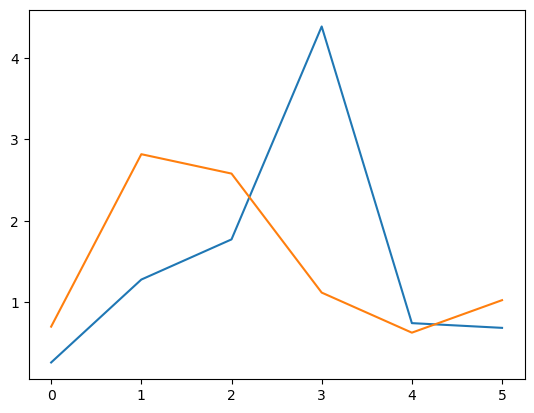

In [70]:
print(MSE(np.array(y_test),np.array(y_predict)))
print(MSE(y_test[50],y_predict[50]))
plt.plot(y_test[50])
plt.plot(y_predict[50])

La prédiction correspond à tous les signaux corrélées au dela d 'un certain seuil.

100%|██████████| 170/170 [00:14<00:00, 12.03it/s]


0.8591518977388878


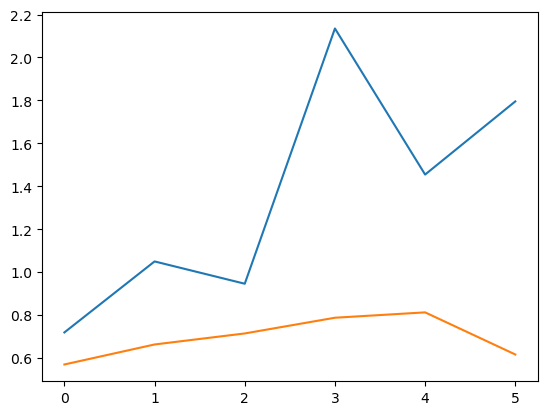

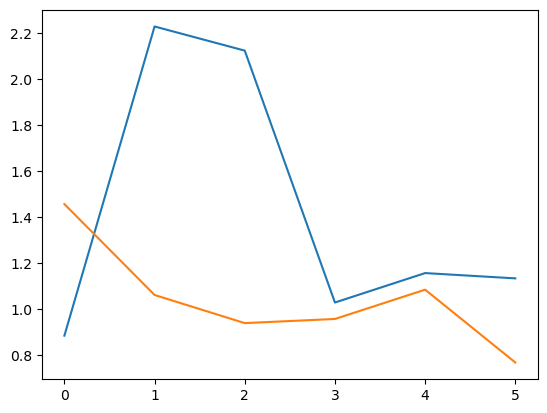

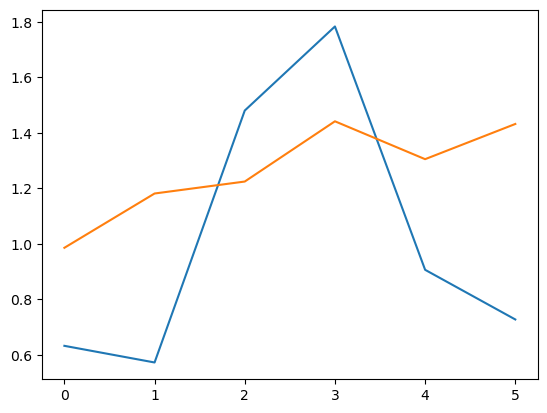

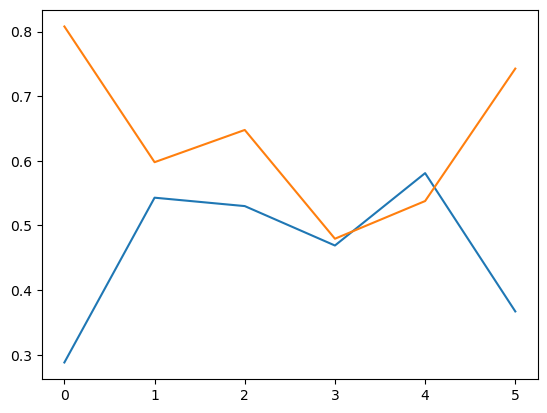

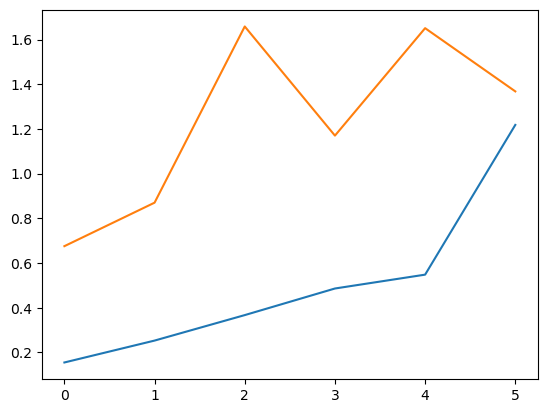

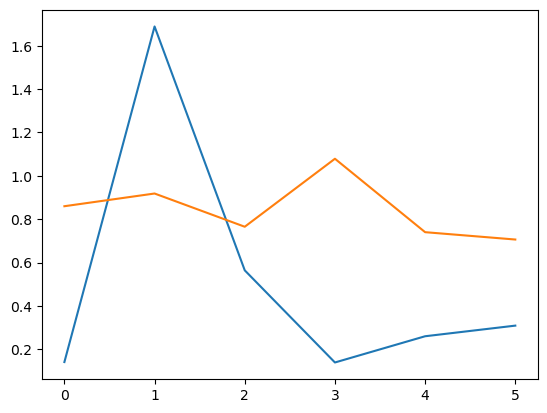

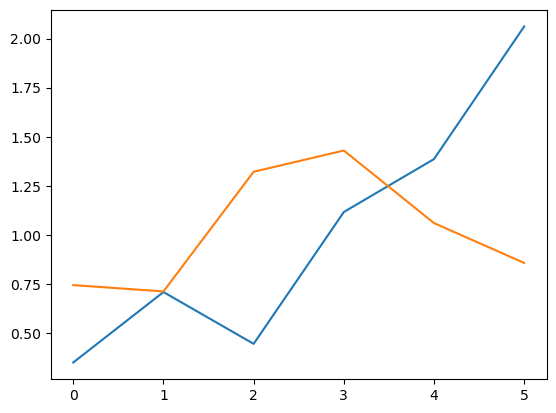

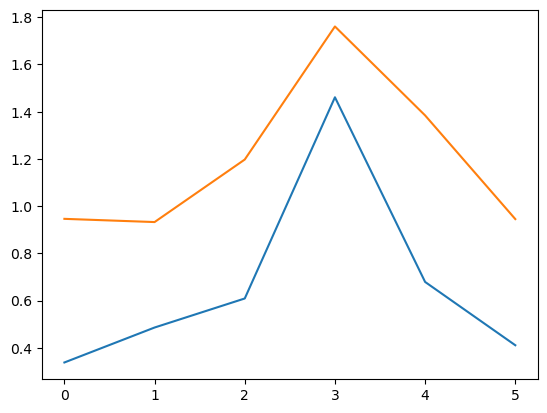

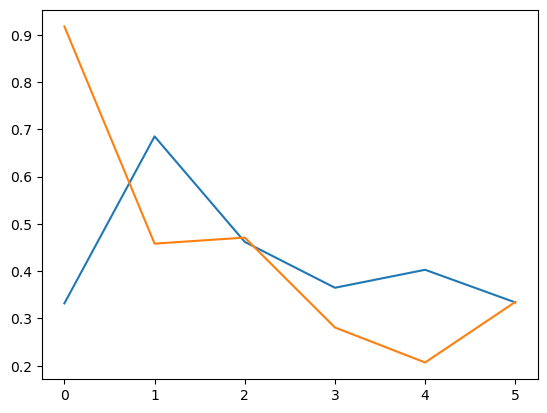

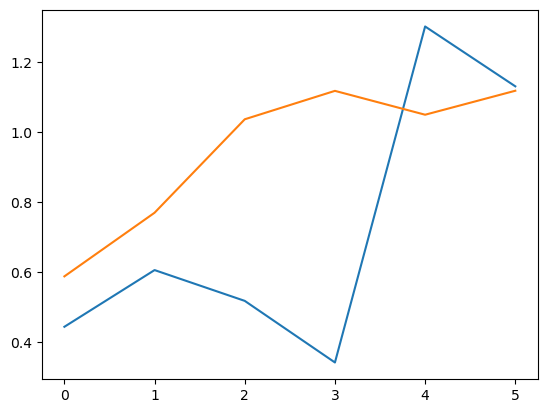

In [71]:
def predict_multi(start_time,end_time,id_client, delta_time,coef):
    delta_i = delta_time.days*48
    length_to_predict = (end_time-start_time).seconds//1800
    big_signal = np.array(load_signal(id_client, min_date+18*hour,start_time-delta_time))
    signal_to_use = np.array(load_signal(id_client, start_time-delta_time,start_time))
    signal_to_use = centered(signal_to_use)
    corr = correlation(big_signal,signal_to_use)
    id_max = np.argmax(corr)
    corr_max = corr[id_max]

    n_signals=0
    mean_signal = big_signal[:length_to_predict]*0
    for id,co in enumerate(corr):
        if co>=corr_max*coef and len(big_signal[id*48+delta_i:id*48+delta_i+length_to_predict])==len(mean_signal):
            n_signals+=1
            mean_signal = mean_signal + big_signal[id*48+delta_i:id*48+delta_i+length_to_predict]
    return mean_signal/n_signals




y_predict = []
y_test = []
for id in client_challenges[5:7]:
    for n_day in tqdm(range(n_days)):
        start_time = min_date+(365+n_day)*day+18*hour
        end_time = min_date+(365+n_day)*day+21*hour
        delta_time = day
        true_signal = np.array(load_signal(id,start_time,end_time))
        signal_predict = predict_multi(start_time,end_time,id,delta_time,0.8)
        signal_previous = np.array(load_signal(id,start_time-day,start_time))
        y_predict.append(signal_predict)
        y_test.append(true_signal)




y_test = np.array(y_test)
y_predict = np.array(y_predict)
print(MSE(y_test,y_predict))

for i in range(20,30):
    plt.plot(y_test[10*i])
    plt.plot(y_predict[10*i])
    plt.show()
